In [3]:
import collections
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from skimage import exposure
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import cv2
fontprops = fm.FontProperties(size=34)
from sklearn.neighbors import NearestNeighbors
from skimage import color, measure, filters
import seaborn as sns
from matplotlib.colors import ListedColormap
import os
import skimage
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skimage import filters
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.filters import gaussian
from skimage.filters.rank import median
from skimage.morphology import disk, ball

import scipy.cluster.hierarchy as sch


%load_ext autoreload
%autoreload 2

# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
    

from config import *
import my_io as io

# Import metadata information

df_metadata = pd.read_csv(data_dir / 'metadata.csv')
df_metadata.head()

datasets = df_metadata.Directory.to_list()
datasets = [name.split('\\')[-1] for name in datasets]

print(datasets)

['ROI001_B1', 'ROI005_B3', 'ROI006_B5', 'ROI007_C6', 'ROI008_D7', 'ROI009_D9', 'ROI012_E1', 'ROI015_B6', 'ROI016_F3', 'ROI017_F2', 'ROI018_G1', 'ROI019_G5', 'ROI020_E5', 'ROI021_E7']


# Get cell type

In [4]:
def read_cell_mask(ROI: str):
    """Read all image from one ROI"""
    dir_ = data_figure / 'mask_DL'

    # Get images in directory
    dirpath, _, filenames = next(os.walk(dir_))
    for name in filenames:
        if 'both' in name:
            continue
        elif ROI in name and 'cyto' in name:
            mask_name = name
    mask = skimage.io.imread(os.path.join(dirpath, mask_name))
    return mask

def get_cell_expression_level_mean(imgs_list, labels, cell_mask):
    # Multiple each cell region by mean intensity 
    df_list = []
    for idx, img in enumerate(imgs_list):
        exp_prop = pd.DataFrame(measure.regionprops_table(cell_mask, img, properties=['label','mean_intensity'])).set_index('label')

        df = exp_prop.rename(columns = {'mean_intensity': labels[idx]}, errors = 'raise')
        df_list.append(df)
    df_exp = pd.concat(df_list, axis=1)
    return df_exp

def get_cell_color(df, labels, rgb):

    label2num = dict(zip(labels, [i for i in range(len(labels))]))
    num2color = dict([(i, rgb[i]/255) for i in range(len(labels)+1)])
    
    cell_max_marker = df.idxmax(axis=1)
    cell_max_marker = cell_max_marker.apply(label2num.get)
    
    cell_max_color = cell_max_marker.apply(num2color.get)
    
    return cell_max_marker.to_dict(), cell_max_color.values

def replace_with_dict(ar, dic):
    new_dict = dic.copy()
    new_dict[0] = np.nan
    
    # Extract out keys and values
    k = np.array(list(new_dict.keys()))
    v = np.array(list(new_dict.values()))

    # Get argsort indices
    sidx = k.argsort()

    ks = k[sidx]
    vs = v[sidx]
    return vs[np.searchsorted(ks,ar)]

def myround(x, base=5):
    return base * round(x/base)

In [5]:
def plot_linkage(df, path):
    df_subset = df.iloc[:,:-1]
    df_subset['CD20'] = df_subset['CD20'] + np.random.normal(0,1,len(df))
    df_subset.columns = ['Tumor', 'IP', 'IN', 'Stroma'] + df_subset.iloc[:,4:].columns.tolist()
    
    # Get linkage
    d = sch.distance.pdist(df_subset.T, metric='cosine')
    L = sch.linkage(d, method="average")

    ax = sns.clustermap(df_subset.corr(), 
                        cmap='bwr',
                        cbar_kws={"fraction": 0.01},
                        linewidth=0.1,
                        dendrogram_ratio=(0.1, 0.1),
                        figsize=(6, 6),
                       row_linkage=L,
                       col_linkage=L)
    ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xticklabels(),rotation=30)
    
    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar

    pos = ax.ax_heatmap.get_position()
    cbar_size=0.2
    ax.ax_cbar.set_position((1., pos.y0, .03, cbar_size))

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)
        
    ax.savefig(path)

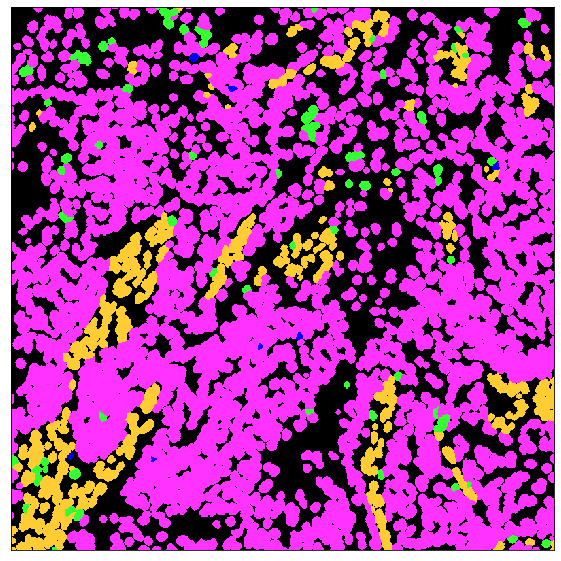

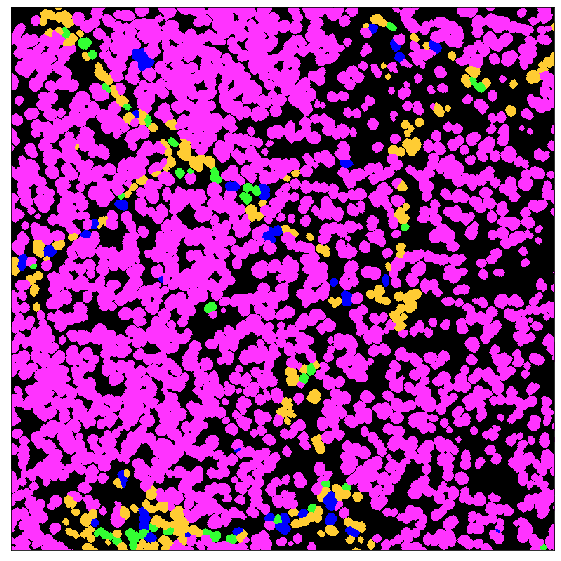

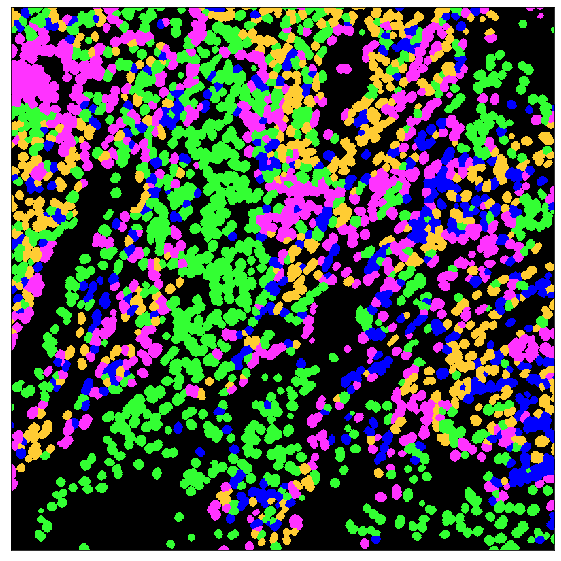

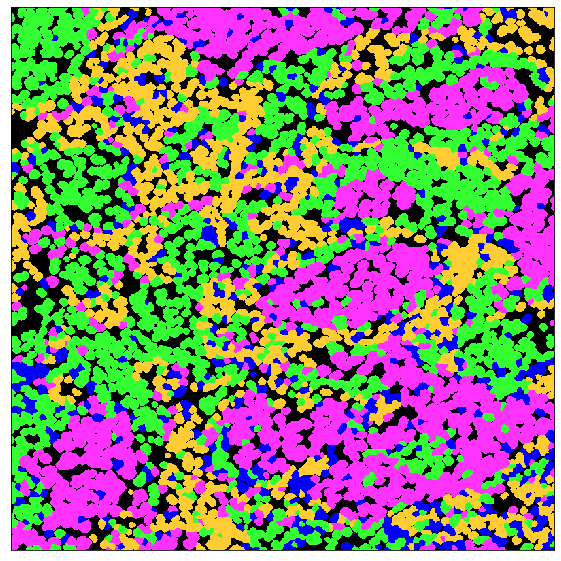

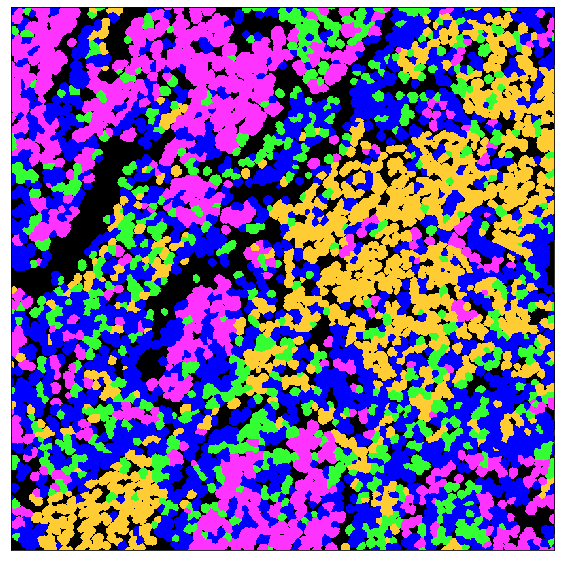

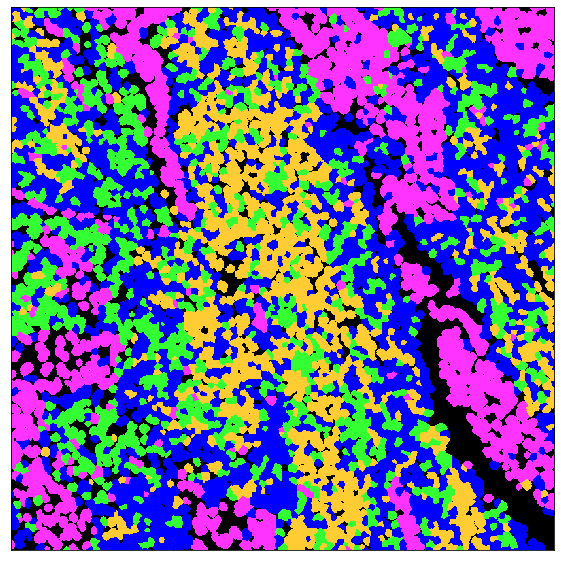

In [7]:
marker_list = [['ECadherin','PanKeratin'], ['CD68'],['CD8a'], ['Col1', 'SMA']]
labels = ['ECA+PanK', 'CD68', 'CD8a', 'Col1+SMA']

datasets = ['ROI001_B1',
            'ROI021_E7',
            'ROI017_F2',
            'ROI008_D7',
            'ROI012_E1',
            'ROI016_F3'
           ]
Immune_type = ['Immune Cold', 'Immune Cold', 'Immune Suppresed', 'Immune Suppresed', 'Immune inflamed', 'Immune inflamed']

study_list = ['FoxP3', 'CD4', 'CD20', 'GranzymeB', 'CD45RO', 'CD3']

rgb = np.array([[255,0,255], [0,255,0], [0,255,255], [255,255,0], [160,160,160]])
mycmap = ListedColormap(rgb/255)
rgb2 = np.array([[255,51,255], [51,255,51], [0,0,255], [255,204,51], [160,160,160]])
mycmap2 = ListedColormap(rgb2/255)

show=True
n = 25

df_list = []

for i, dataset in enumerate(datasets):

    # Read image and cell_mask
    imgs, markers = io.read_img(dataset, data_ROI)
    marker2img = dict(zip(markers, imgs))
    cell_mask = read_cell_mask(dataset)
#     cell_mask = io.read_cell_mask(dataset, data_ROI)
    min_shape = min(cell_mask.shape[0], cell_mask.shape[1])
    min_shape = myround(min_shape, base=n)
    cell_mask = cell_mask[:min_shape, :min_shape]
    
    imgs_list = []
    for markers in marker_list:
        temp = []
        for marker in markers:
            img = marker2img[marker]
            if marker == 'CD8a':
                img = median(img, disk(1))
            p2, p98 = np.percentile(img, (0, 99.9))
            img = exposure.rescale_intensity(img, in_range=(p2, p98))
            temp.append(img[:min_shape, :min_shape])
        imgs_list.append(np.array(np.mean(temp, axis=(0))))
    
    imgs_study_list = [] # Other marker list
    for marker in study_list:
        img = marker2img[marker]
        img = median(img, disk(1))
        p2, p98 = np.percentile(img, (0, 99.9))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        imgs_study_list.append(img[:min_shape, :min_shape])
    
    # Grayscale backgroun image
    avg_img = np.array(np.mean(imgs, axis=(0)))[:min_shape, :min_shape]

    # Get both cell type markers and study marker images and labels
    df = get_cell_expression_level_mean(imgs_list+imgs_study_list, labels+study_list, cell_mask)
    df['ECA+PanK'] = df['ECA+PanK'] * 0.6
    node_class, node_colors = get_cell_color(df.iloc[:, :4], labels, rgb) # Cell classification only with first 4 columns
    
    #Plot cell mask
    img = replace_with_dict(cell_mask , node_class)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img, cmap=mycmap2, interpolation='None', vmin=0, vmax=5)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('black')
    
    df['Type'] = pd.Series(node_class, index=df.index, dtype=int).astype("category").map({0:'Tumor', 1:'IN', 2:'IP',3:'Stroma'})
    df['Immune Type'] = Immune_type[i]
    
    df_list.append(df)
                    

In [11]:
df_all = pd.concat(df_list)

In [20]:
df_all

,ECA+PanK,CD68,CD8a,Col1+SMA,FoxP3,CD4,CD20,GranzymeB,CD45RO,CD3,Type,Immune Type
label,,,,,,,,,,,,
1,44.331429,13.971429,60.228571,22.457143,0.000000,0.000000,0.000000,11.828571,96.371429,4.885714,IP,Immune Cold
2,28.863462,13.980769,8.115385,5.701923,0.000000,0.000000,0.000000,0.000000,26.961538,0.000000,Tumor,Immune Cold
3,46.147826,6.826087,2.942029,13.463768,5.681159,2.985507,0.000000,0.000000,82.376812,4.956522,Tumor,Immune Cold
4,18.444000,27.160000,0.000000,12.190000,19.600000,17.020000,0.000000,11.300000,70.900000,27.720000,IN,Immune Cold
5,33.338462,12.564103,0.000000,14.987179,0.000000,3.358974,0.000000,4.794872,32.153846,0.000000,Tumor,Immune Cold
...,...,...,...,...,...,...,...,...,...,...,...,...
5633,17.259000,16.270000,36.360000,63.720000,11.820000,1.700000,6.860000,4.290000,62.080000,53.620000,Stroma,Immune inflamed
5634,16.652239,31.671642,45.044776,20.216418,5.880597,14.552239,0.000000,52.492537,113.089552,88.298507,IP,Immune inflamed
5635,12.380000,28.033333,51.933333,27.883333,0.000000,9.333333,0.000000,4.966667,68.366667,39.166667,IP,Immune inflamed


# Plot per immune score info

C:\Users\thu71\.conda\envs\spatial_signaling\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


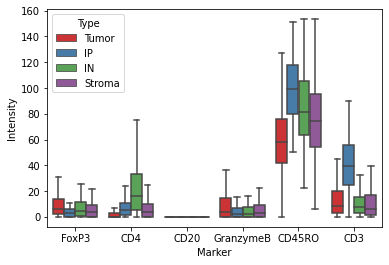

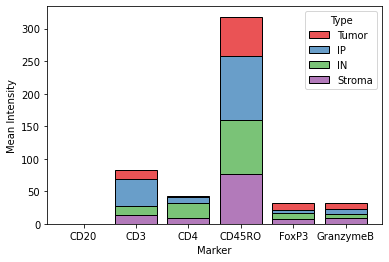

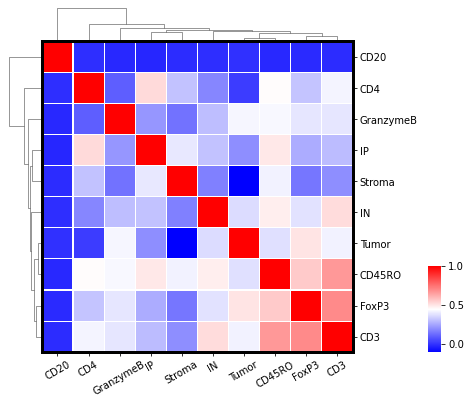

In [15]:
immmune = 'Immune Cold'
df = df_all[df_all['Immune Type'] == immmune ]
df.drop('Immune Type', inplace=True, axis=1)

df_melt = df.iloc[:,4:].melt(id_vars='Type', var_name='Marker', value_name='Intensity')

fig, ax = plt.subplots(figsize=(6,4))
ax = sns.boxplot(data = df_melt, 
                 x='Marker', 
                 y='Intensity', 
                 hue='Type', 
                 palette="Set1", 
                 hue_order=['Tumor', 'IP', 'IN', 'Stroma'],
                 showfliers=False
                )
fig.savefig(data_figure / 'border' / f'stats_{immmune}.png', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(data = df_melt.groupby(['Type', 'Marker']).mean().reset_index(), 
                 x='Marker', 
                 weights='Intensity', 
                 hue='Type', 
                 multiple='stack', 
                 palette="Set1", 
                 hue_order=['Tumor', 'IP', 'IN', 'Stroma'], shrink=0.8)
ax.set_ylabel('Mean Intensity')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
fig.savefig(data_figure / 'border' / f'stats2_{immmune }.png', bbox_inches='tight')

plot_linkage(df, data_figure / 'border' / f'corr_{immmune }.png')


C:\Users\thu71\.conda\envs\spatial_signaling\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


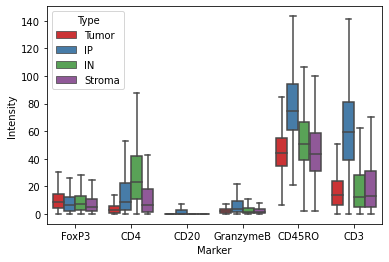

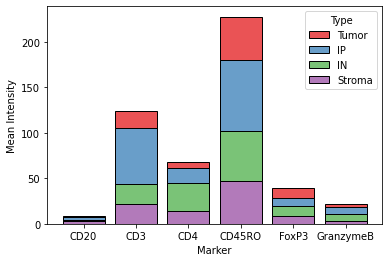

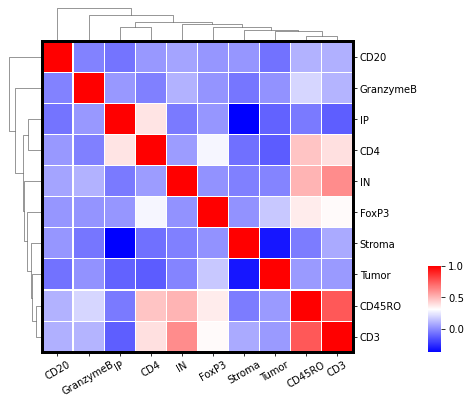

In [16]:
immmune = 'Immune Suppresed'
df = df_all[df_all['Immune Type'] == immmune ]
df.drop('Immune Type', inplace=True, axis=1)

df_melt = df.iloc[:,4:].melt(id_vars='Type', var_name='Marker', value_name='Intensity')

fig, ax = plt.subplots(figsize=(6,4))
ax = sns.boxplot(data = df_melt, 
                 x='Marker', 
                 y='Intensity', 
                 hue='Type', 
                 palette="Set1", 
                 hue_order=['Tumor', 'IP', 'IN', 'Stroma'],
                 showfliers=False
                )
fig.savefig(data_figure / 'border' / f'stats_{immmune}.png', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(data = df_melt.groupby(['Type', 'Marker']).mean().reset_index(), 
                 x='Marker', 
                 weights='Intensity', 
                 hue='Type', 
                 multiple='stack', 
                 palette="Set1", 
                 hue_order=['Tumor', 'IP', 'IN', 'Stroma'], shrink=0.8)
ax.set_ylabel('Mean Intensity')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
fig.savefig(data_figure / 'border' / f'stats2_{immmune }.png', bbox_inches='tight')

plot_linkage(df, data_figure / 'border' / f'corr_{immmune }.png')

C:\Users\thu71\.conda\envs\spatial_signaling\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


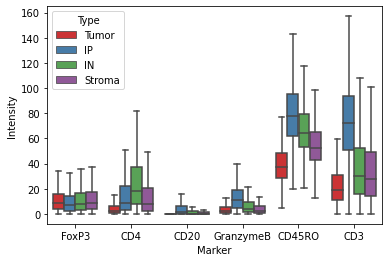

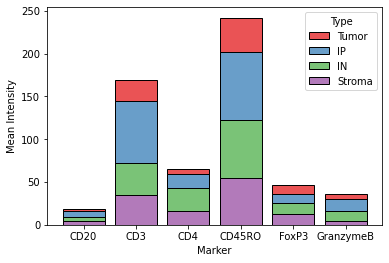

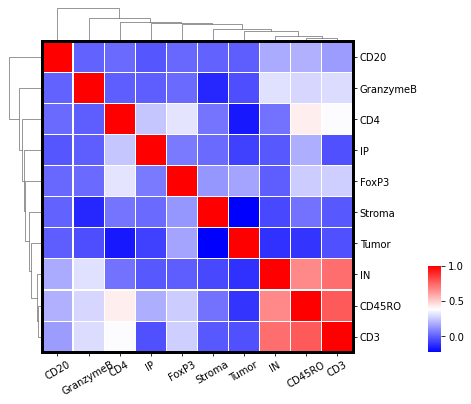

In [18]:
immmune = 'Immune inflamed'
df = df_all[df_all['Immune Type'] == immmune ]
df.drop('Immune Type', inplace=True, axis=1)

df_melt = df.iloc[:,4:].melt(id_vars='Type', var_name='Marker', value_name='Intensity')

fig, ax = plt.subplots(figsize=(6,4))
ax = sns.boxplot(data = df_melt, 
                 x='Marker', 
                 y='Intensity', 
                 hue='Type', 
                 palette="Set1", 
                 hue_order=['Tumor', 'IP', 'IN', 'Stroma'],
                 showfliers=False
                )
fig.savefig(data_figure / 'border' / f'stats_{immmune}.png', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.histplot(data = df_melt.groupby(['Type', 'Marker']).mean().reset_index(), 
                 x='Marker', 
                 weights='Intensity', 
                 hue='Type', 
                 multiple='stack', 
                 palette="Set1", 
                 hue_order=['Tumor', 'IP', 'IN', 'Stroma'], shrink=0.8)
ax.set_ylabel('Mean Intensity')
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
fig.savefig(data_figure / 'border' / f'stats2_{immmune }.png', bbox_inches='tight')

plot_linkage(df, data_figure / 'border' / f'corr_{immmune }.png')